In [137]:
# Manipulação de pastas
import os

# Outras bibliotecas necessárias
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import IPython.display as ipd

certo = 0
errado = 0

data, fs = librosa.load('treino/x7cc.wav', None)
valor = separar_letras(data,fs)
    
for root, dirs, files in os.walk("treino/"):  
    for filename in files:
        data, fs = librosa.load('treino/' + filename, None)
        valor = separar_letras(data,fs)
        if (valor == 4):
            certo = certo + 1
        else: 
            errado = errado + 1
            print (valor)

print ("Certo: ")
print (certo)
print ("Errado: ")
print (errado)

Certo: 
200
Errado: 
0


In [136]:
def separar_letras(data, fs) :

    #Separar em 4 conjuntos 
    n = 4
    splited = []
    len_l = len(data)
    for i in range(n):
        start = int(i*len_l/n)
        end = int((i+1)*len_l/n)
        splited.append(data[start:end])
    
    frame_lenght = 6300 # frames de fs/14 aprox 0.5s
    
    chars_values = list()
    
    for audioPart in range(4):
        initial_frame_pos = 0 
        frames_list = list()

        #Separando os frames
        while initial_frame_pos < len(splited[audioPart]):
            frames_list.append(splited[audioPart][initial_frame_pos : initial_frame_pos+frame_lenght])
            initial_frame_pos += frame_lenght

        #Filtrando por amplitude maxima do frame inicial (supondo que é sempre ruido ou silencio) + desvio padrao
        amp_cat_values = list()

        max_values = [max(x) for x in frames_list] 
        max_values.sort()
        max_value_mean = np.mean(max_values)
        max_value_std = np.std(max_values)

        for frame in frames_list:
            frame_max = max(abs(frame))
            #se o frame tiver amplitude maxima <= a inicial std consideramos como um trecho de audio valido      
            if frame_max <= max_value_mean + max_value_std**2 :  
                if frame_max >= max_value_mean - max_value_std**2 :
                    amp_cat_values.append("max")
                else:
                    amp_cat_values.append("min")
            else:
                amp_cat_values.append("max")

        # guardando os idices dos frames de frames_list onde a amplitude equivale a um valor de audio valido
        max_indexes = list()
        index_list = range(0, len(amp_cat_values))
        amp_cat_values = list(zip(index_list, amp_cat_values))

        max_indexes = [index for index in amp_cat_values if index[1] is "max"]

        #agrupando por indices a uma distancia <= 2 posições (separando os caracteres)
        chars_indexes = list()
        new_frame = list()
        new_frame.append(max_indexes[0])
        for frame_info in max_indexes:
            if frame_info[0] - new_frame[-1][0] <= 2:
                if frame_info not in new_frame:
                    new_frame.append(frame_info)
            else:
                chars_indexes.append(new_frame)
                new_frame = list()
                new_frame.append(frame_info)
            if frame_info is max_indexes[-1]:
                chars_indexes.append(new_frame)

        # filtrando os indices no vetor de frames_list (contendo as amostras originais) para separar as amostras de
        # caracteres validos
        initialBigger = 0
        lastBigger = 0

        diferenca = 0

        for index in chars_indexes:
            initial = index[0][0] 
            last = index[-1][0] 

            if (last - initial) > diferenca:
                initialBigger = initial
                lastBigger = last

        value = np.hstack(frames_list[initialBigger:lastBigger])
        chars_values.append(value)

    return len(chars_values)

In [171]:
data, fs = librosa.load('treino/x7cc.wav', None)

#Separar em 4 conjuntos 
n = 4
splited = []
len_l = len(data)
for i in range(n):
    start = int(i*len_l/n)
    end = int((i+1)*len_l/n)
    splited.append(data[start:end])
    
frame_lenght = 6300 # frames de fs/14 aprox 0.5s
    
chars_values = list()
    
for audioPart in range(4):
    initial_frame_pos = 0 
    frames_list = list()

    #Separando os frames
    while initial_frame_pos < len(splited[audioPart]):
        frames_list.append(splited[audioPart][initial_frame_pos : initial_frame_pos+frame_lenght])
        initial_frame_pos += frame_lenght

    #Filtrando por amplitude maxima do frame inicial (supondo que é sempre ruido ou silencio) + desvio padrao
    amp_cat_values = list()

    max_values = [max(x) for x in frames_list] 
    max_values.sort()
    max_value_mean = np.mean(max_values)
    max_value_std = np.std(max_values)

    for frame in frames_list:
        frame_max = max(abs(frame))
        #se o frame tiver amplitude maxima <= a inicial std consideramos como um trecho de audio valido      
        if frame_max <= max_value_mean + max_value_std**2 :  
            if frame_max >= max_value_mean - max_value_std**2 :
                amp_cat_values.append("max")
            else:
                amp_cat_values.append("min")
        else:
            amp_cat_values.append("max")

    # guardando os idices dos frames de frames_list onde a amplitude equivale a um valor de audio valido
    max_indexes = list()
    index_list = range(0, len(amp_cat_values))
    amp_cat_values = list(zip(index_list, amp_cat_values))

    max_indexes = [index for index in amp_cat_values if index[1] is "max"]

    #agrupando por indices a uma distancia <= 2 posições (separando os caracteres)
    chars_indexes = list()
    new_frame = list()
    new_frame.append(max_indexes[0])
    for frame_info in max_indexes:
        if frame_info[0] - new_frame[-1][0] <= 2:
            if frame_info not in new_frame:
                new_frame.append(frame_info)
        else:
            chars_indexes.append(new_frame)
            new_frame = list()
            new_frame.append(frame_info)
        if frame_info is max_indexes[-1]:
            chars_indexes.append(new_frame)

    # filtrando os indices no vetor de frames_list (contendo as amostras originais) para separar as amostras de
    # caracteres validos
    initialBigger = 0
    lastBigger = 0

    diferenca = 0

    for index in chars_indexes:
        initial = index[0][0] 
        last = index[-1][0] 

        if (last - initial) > diferenca:
            initialBigger = initial
            lastBigger = last

    value = np.hstack(frames_list[initialBigger-1:lastBigger+1])
    chars_values.append(value)

[0.00164795 0.00039673 0.         ... 0.01818848 0.01721191 0.01696777]


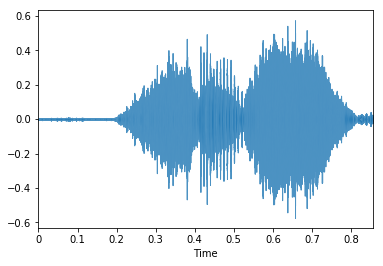

In [172]:
print(chars_values[0])
librosa.display.waveplot(chars_values[0], fs, alpha=0.8)
ipd.Audio(chars_values[0], rate=fs)

[ 0.00067139 -0.00064087  0.00140381 ... -0.01046753 -0.01004028
 -0.0071106 ]


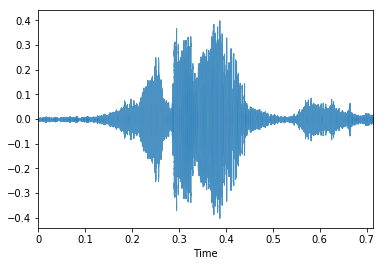

In [173]:
print(chars_values[1])
librosa.display.waveplot(chars_values[1], fs, alpha=0.8)
ipd.Audio(chars_values[1], rate=fs)

[ 9.1552734e-05  0.0000000e+00  1.2207031e-04 ... -6.4086914e-04
 -6.4086914e-04 -7.0190430e-04]


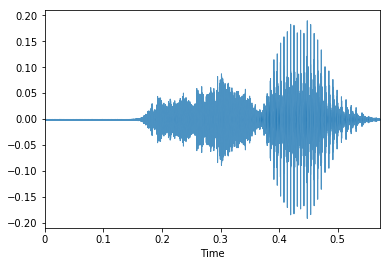

In [174]:
print(chars_values[2])
librosa.display.waveplot(chars_values[2], fs, alpha=0.8)
ipd.Audio(chars_values[2], rate=fs)

[-1.2207031e-04 -9.1552734e-05 -3.6621094e-04 ...  9.3383789e-03
  9.3994141e-03  9.2773438e-03]


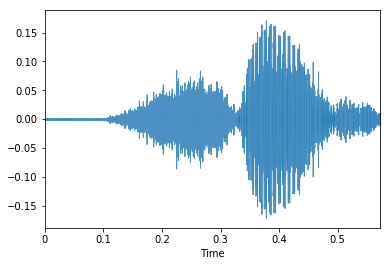

In [175]:
print(chars_values[3])
librosa.display.waveplot(chars_values[3], fs, alpha=0.8)
ipd.Audio(chars_values[3], rate=fs)

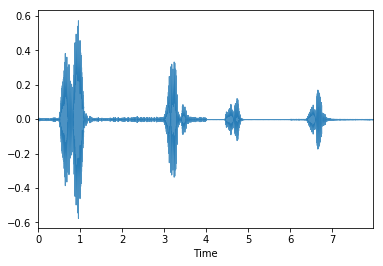

In [176]:
librosa.display.waveplot(data, fs, alpha=0.8)
ipd.Audio(data, rate=fs)